In [10]:
import pandas as pd
import glob
import os
#os.getcwd()
os.chdir("/home/matthew/anaconda3/envs/insight/staycationLA/data/raw")

In [11]:
#load data (from NB04 LA attraction reviews combine)
LA = pd.read_csv("../processed/LA_combined_reviews.csv", index_col=None)
pos=LA['stars'] > 35
pos_LA=LA[pos]
pos_LA2=pos_LA.drop(['title', 'text'], axis=1)
pos_LA2 = pos_LA2.drop_duplicates()
len(pos_LA2)

126362

In [12]:
is_NaN = pos_LA2. isnull()
row_has_NaN = is_NaN. any(axis=1)
rows_with_NaN = pos_LA2[row_has_NaN]
pos_LA3=pos_LA2.dropna()
pos_LA3.reset_index()
len(rows_with_NaN)

43

In [13]:
LA2=LA.drop(['stars', 'title', 'text'], axis=1)
LA3=LA2.dropna()
LA4=LA3.groupby('attraction').count()
#LA5=LA4['user'] > 1 #remove all attractions with only 1 review

# Get names of indexes for attractions with only 1 review
indexNames = LA4[ LA4['user'] == 1 ].index
# Delete these row indexes from dataFrame
LA4.drop(indexNames , inplace=True)
# Get names of indexes for attractions with only 2 review
indexNames = LA4[ LA4['user'] == 2 ].index
# Delete these row indexes from dataFrame
LA4.drop(indexNames , inplace=True)
len(LA4)

1039

In [14]:
#read the csf (created in NB05 scrape LA reviewer travel history)
trav_hist = pd.read_csv("../processed/LA_combined_user_travel_hist.csv", index_col=None)
trav_hist = trav_hist.drop_duplicates()
len(trav_hist)

3077993

In [15]:
LA = pd.read_csv("../processed/LA_final_corpora.csv", index_col=None)
len(LA)

1335

In [16]:
#remove a few more weird attractions
LA = LA[~LA['attraction'].isin(['Psychiatry_An_Industry_of_Death'])]#scientology propaganda museum
LA = LA[~LA['attraction'].isin(['Foothill_Transit'])]#bus
LA = LA[~LA['attraction'].isin(['Williams_Hart_Transportation'])]#limo
LA = LA[~LA['attraction'].isin(['Union_Station'])]#transportation
LA = LA[~LA['attraction'].isin(['Museum_of_Death'])]#wierd museum
LA = LA[~LA['attraction'].isin(['WiFi_rental_around_world_Vision_Global_WiFi'])]#wierd museum
LA = LA[~LA['attraction'].isin(['Los_Angeles_Convention_Center'])]#convention center has many different events- don't want to just recommend the center itself
LA = LA[~LA['type'].isin(['Visitor Centers'])]
LA = LA[~LA['type'].isin(['Rides & Activities'])]
LA = LA[~LA['type'].isin(['Arenas & Stadiums'])]
LA = LA[~LA['type'].isin(['Breweries'])]
LA = LA[~LA['type'].isin(['Distilleries'])]
LA = LA[~LA['type'].isin(['Theme Parks'])]
LA = LA[~LA['type'].isin(['Water Parks'])]

#LA = LA[~LA['type'].isin(['Shopping Malls'])]
LA_clean = LA.reset_index(drop=True)
len(LA_clean)

1250

In [17]:
pd.options.display.max_colwidth = 20
LA_clean.head(10)

,attraction,english,TA_url,rating,gps,url,type,name,pic,num_reviews,ranking
0,Griffith_Observa...,griffith observa...,https://www.trip...,4.5,"[('34.118492', '...",http://www.griff...,Observatories & ...,<a href='https:...,<img class='img-...,20247,#2
1,Santa_Monica_Pier,end mother road ...,https://www.trip...,4.0,"[('34.01038', '-...",http://santamoni...,Points of Intere...,<a href='https:...,<img class='img-...,18866,#3
2,Hollywood_Walk_o...,exciting crowded...,https://www.trip...,3.5,"[('34.1016', '-1...",http://www.walko...,Points of Intere...,<a href='https:...,<img class='img-...,17542,#4
3,The_Getty_Center,accidentally pre...,https://www.trip...,5.0,"[('34.077564', '...",http://www.getty...,Specialty Museums,<a href='https:...,<img class='img-...,14503,#5
4,Venice_Beach,crazy think craz...,https://www.trip...,4.0,"[('33.985912', '...",https://www.trip...,Beaches,<a href='https:...,<img class='img-...,10729,#6
5,Hollywood_Sign,beautiful landma...,https://www.trip...,4.0,"[('34.134113', '...",http://www.visit...,Points of Intere...,<a href='https:...,<img class='img-...,7648,#7
6,Santa_Monica_Sta...,santa beach beac...,https://www.trip...,4.5,"[('34.0114', '-1...",http://www.smgov...,State Parks,<a href='https:...,<img class='img-...,6697,#8
7,Rodeo_Drive,pretty shop supe...,https://www.trip...,4.0,"[('34.06983', '-...",http://www.bever...,Points of Intere...,<a href='https:...,<img class='img-...,5491,#9
8,Santa_Monica_Bay,wonderfully rela...,https://www.trip...,4.5,"[('34.008915', '...",https://www.trip...,Bodies of Water,<a href='https:...,<img class='img-...,5343,#10
9,Madame_Tussauds_...,love recently vi...,https://www.trip...,4.5,"[('34.101566', '...",http://www.madam...,Specialty Museums,<a href='https:...,<img class='img-...,3255,#13


In [18]:
def top10 (cityname):
    '''
    function to calculate proportion of people who went to a city (eg Istanbul) who also left a postive (4-5 star) review on any LA attraction. This proportion ("pop_control) is then multiplied by the log total # of reviews (to weight for popularity slightly) to get a score. This score is the "right answer" which can be used to evaluate the recommender algorithm.
    '''
    city=trav_hist[trav_hist['place'].str.contains(cityname)]
    city['user'] = city['user'].astype(str)
    city_users = city['user'].tolist()
    merged_inner = pd.merge(left=pos_LA3, right=city, left_on='user', right_on='user')
    merged_inner = merged_inner.drop_duplicates()
    frame2 = merged_inner.drop(['stars', 'tag', 'place'], axis=1)
    frame2 = frame2.drop_duplicates()
    frame3 = frame2.groupby('attraction').count()
    frame4 = frame3.sort_values(by='user', ascending=False)
    merged_inner = pd.merge(left=LA4, right=frame4, left_on='attraction', right_on='attraction')
    merged_inner['pop_control']= merged_inner['user_y']/merged_inner['user_x']
    #user_y = number of people who went to the city and left a positive review, user_x = total number of people who reviewed the attraction

    import numpy as np
    merged_inner['log']= np.log((merged_inner['user_x'])+1)
    #merged_inner['log2']= np.log((merged_inner['log'])+1)
    #merged_inner['sqrt']= np.sqrt((merged_inner['user_x']))
    #merged_inner['sqrt2']= np.sqrt((merged_inner['sqrt']))

    merged_inner['score']= merged_inner['pop_control']*merged_inner['log']
    merged_inner2=merged_inner.sort_values(by='score', ascending=False)
    merged_inner3 = pd.merge(left=merged_inner2, right=LA_clean, left_on='attraction', right_on='attraction')

    return merged_inner3.head(10)
    #len(city_users)

In [19]:
answers = []
cities = ['Istanbul', "Beijing", 'Phuket', 'Santorini', 'Cusco', 'Sydney', 'Florence', 'Jaipur', 'Luxor', 'Marrakech', 'Rio', 'Salzburg', 'Berlin', 'Havana', 'Cape Town', "St. Petersburg", 'Edinburgh', 'Lisbon', 'Tokyo', 'Reykjavik', 'Seville', 'Addis Ababa', 'Hanoi', 'Medellin']

for cityname in cities:
    '''
    extracts "right answer" list of top 10 recommendations based on travel history and populatiry to use in model evaluation (MAP@10)
    '''
    answer = top10(cityname)
    answer_list = answer['attraction'].tolist()
    answers.append(answer_list)
    
answers

<ipython-input-18-661f3013e742>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  city['user'] = city['user'].astype(str)


[['Walt_Disney_Concert_Hall',
  'Los_Angeles_County_Museum_of_Art',
  'The_Getty_Villa',
  'Norton_Simon_Museum',
  'Virginia_Robinson_Gardens',
  'The_Getty_Center',
  'The_Huntington_Library_Art_Museum_and_Botanical_Gardens',
  'The_Broad',
  'Bluff_Park',
  'Griffith_Park'],
 ['Walt_Disney_Concert_Hall',
  'Angelino_Heights_Historic_Area',
  'Virginia_Robinson_Gardens',
  'Los_Angeles_County_Museum_of_Art',
  'The_Getty_Villa',
  'The_Getty_Center',
  'The_Huntington_Library_Art_Museum_and_Botanical_Gardens',
  'Marvin_Braude_Bike_Trail',
  'Jet_Propulsion_Laboratory',
  'Norton_Simon_Museum'],
 ['Odyssey_Theatre',
  'Bluff_Park',
  'Hillside_Memorial_Park',
  'East_4th_Street',
  'Pasadena_Antique_Mall',
  'Dorothy_Chandler_Pavilion',
  'Abalone_Cove_Beach',
  'Historical_Society_of_Long_Beach',
  'Belmont_Veterans_Memorial_Pier',
  'El_Rancho_Escondido'],
 ['Rustic_Canyon_Park',
  'Sullivan_Canyon',
  'Super_Silly_Fun_Land',
  'Summit_Valley_Edmund_D_Edelman_Park',
  'Mary_Hotchki

In [20]:
recs = []
for cityname in cities:
    '''
    extracts list of top 10 recommendations from my algorithm to use in model evaluation (MAP@10)
    '''
    rec = pd.read_csv('../cleaned/city_' + cityname + '_df.csv', index_col=None)
    rec2= rec[:10]
    new = rec2['name'].str.split(pat = "-", expand=True)
    rec_list = new[4].tolist()
    recs.append(rec_list)
    #print (new)
    
recs

[['Wat_Thai_of_Los_Angeles',
  'LA_Fashion_District',
  'Rodeo_Drive',
  'Malibu_Hindu_Temple',
  'Chinatown',
  'The_Santee_Alley',
  'Vine_Vera',
  'Montana_Avenue',
  'American_Museum_of_Ceramic_Art',
  'Abbot_Kinney_Boulevard'],
 ['Chinatown',
  'Chinese_American_Museum',
  'Hsi_Lai_Temple',
  'Chen_Art_Gallery',
  'Hollywood_Walk_of_Fame',
  'The_Huntington_Library_Art_Museum_and_Botanical_Gardens',
  'Hollywood_Boulevard',
  'Discovery_Cube_Los_Angeles',
  'Mie_Pearl_Jewerly',
  'Pacific_Asia_Museum'],
 ['Santa_Monica_State_Beach',
  '26_Mile_Bike_Path',
  'Zuma_Beach',
  'Hermosa_Beach_Pier',
  'Manhattan_Beach',
  'Manhattan_Beach_Pier',
  'Redondo_Beach',
  'Santa_Monica_Bay',
  'Catalina_Express',
  'Santa_Cruz_Island'],
 ['Santa_Cruz_Island',
  'Catalina_Express',
  'Anacapa_Island',
  'The_Sea_Caves',
  'Two_Harbors',
  'Santa_Rosa_Island',
  'Redondo_Beach_Whale_Watch',
  'Channel_Islands_National_Marine_Sanctuary',
  'Catalina_Island_Conservancy',
  'South_Bay_Sailing'],


In [35]:
import ml_metrics as metrics
rec_map = metrics.mapk(answers, recs, 10)

In [22]:
#now compare to popularity baseline
LA_clean2= LA_clean[:10]
pop_b = LA_clean2['attraction'].tolist()
pop_list = [pop_b]*24
pop_list

[['Griffith_Observatory',
  'Santa_Monica_Pier',
  'Hollywood_Walk_of_Fame',
  'The_Getty_Center',
  'Venice_Beach',
  'Hollywood_Sign',
  'Santa_Monica_State_Beach',
  'Rodeo_Drive',
  'Santa_Monica_Bay',
  'Madame_Tussauds_Hollywood'],
 ['Griffith_Observatory',
  'Santa_Monica_Pier',
  'Hollywood_Walk_of_Fame',
  'The_Getty_Center',
  'Venice_Beach',
  'Hollywood_Sign',
  'Santa_Monica_State_Beach',
  'Rodeo_Drive',
  'Santa_Monica_Bay',
  'Madame_Tussauds_Hollywood'],
 ['Griffith_Observatory',
  'Santa_Monica_Pier',
  'Hollywood_Walk_of_Fame',
  'The_Getty_Center',
  'Venice_Beach',
  'Hollywood_Sign',
  'Santa_Monica_State_Beach',
  'Rodeo_Drive',
  'Santa_Monica_Bay',
  'Madame_Tussauds_Hollywood'],
 ['Griffith_Observatory',
  'Santa_Monica_Pier',
  'Hollywood_Walk_of_Fame',
  'The_Getty_Center',
  'Venice_Beach',
  'Hollywood_Sign',
  'Santa_Monica_State_Beach',
  'Rodeo_Drive',
  'Santa_Monica_Bay',
  'Madame_Tussauds_Hollywood'],
 ['Griffith_Observatory',
  'Santa_Monica_Pier',

In [36]:
pop_map = metrics.mapk(answers, pop_list, 10)

In [24]:
#now compare to random baseline
ran_list = []
for x in range(0, 24):
    '''
    extracts 10 random recommendations to use in model evaluation (MAP@10)
    '''
    ran10 = LA_clean.sample(n = 10) 
    ran = ran10['attraction'].tolist()
    ran_list.append(ran)
    #print (new)
    
ran_list

[['Porter_Valley_Winery',
  'Hangar_18_Climbing_Gym_Southbay',
  'Verdugo_Park_Recreation_Center',
  'Zimmer_Children_s_Museum',
  'Santa_Rosa_Island',
  'Fairfax_District',
  'Pacific_Opera_Project',
  'Massage_Envy_Spa_La_Canada_Flintridge',
  'Fort_McArthur_Military_Museum',
  'University_of_Southern_California'],
 ['County_of_Los_Angeles_Public_Library_Avalon_Branch',
  'Animanga',
  'Camarillo',
  'Art_Theatre_of_Long_Beach',
  'United_Artists_Theatre',
  'Carolyn_Campagna_Kleefeld_Contemporary_Art_Museum',
  'Freak_s_Antiques',
  'Westridge_Golf_Club',
  'The_Old_Mill',
  'California_Institute_of_Technology'],
 ['Bolton_Hall_Museum',
  'Drum_Barracks_Civil_War_Museum',
  'Toyota_USA_Automobile_Museum',
  'Rose_Bowl_Stadium',
  'Saddleback_Butte_State_Park',
  'San_Fernando_Mission_Cemetery',
  'Lakewood_Country_Club',
  'Organic_Zen_Spa',
  'Zen_Center_of_Los_Angeles',
  'Topanga_State_Park'],
 ['Vasquez_Rocks_Natural_Area',
  'Long_Beach_East_Village_Arts_District',
  'Charlie_T

In [37]:
ran_map=metrics.mapk(answers, ran_list, 10)

In [26]:
import recmetrics 
#https://github.com/statisticianinstilettos/recmetrics/blob/master/example.ipynb

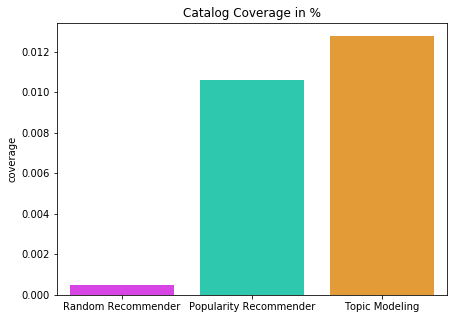

In [40]:
import matplotlib.pyplot as plt
# plot of prediction coverage
coverage_scores = [ran_map, pop_map, rec_map]
model_names = ['Random Recommender', 'Popularity Recommender', 'Topic Modeling']

fig = plt.figure(figsize=(7, 5))
recmetrics.coverage_plot(coverage_scores, model_names)

In [42]:
fig.savefig('../cleaned/MAP@10.png')

In [29]:
catalog = LA_clean.attraction.unique().tolist()
random_coverage = recmetrics.coverage(ran_list, catalog)
pop_coverage = recmetrics.coverage(pop_list, catalog)
LDA_coverage = recmetrics.coverage(recs, catalog)

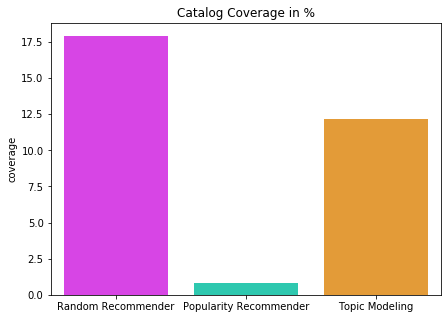

In [43]:
# plot of prediction coverage
coverage_scores = [random_coverage, pop_coverage, LDA_coverage]
model_names = ['Random Recommender', 'Popularity Recommender', 'Topic Modeling']

fig = plt.figure(figsize=(7, 5))
recmetrics.coverage_plot(coverage_scores, model_names)

In [44]:
fig.savefig('../cleaned/coverage.png')

In [32]:
random_coverage

17.92

In [33]:
pop_coverage

0.8

In [34]:
LDA_coverage

12.16